# I’m Something of a Painter Myself Kaggle Mini-Project

This project is my attempt at the "I’m Something of a Painter Myself" Kaggle Mini-Project: https://www.kaggle.com/competitions/gan-getting-started.

The goal of this project was to produce a GAN model that takes an image as an input and turns it into a Monet style painting. 

I ended up following the recomended tutorial notenook by Amy Jang: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial. Therefore, my work is mostly built of of hers. After getting the tutorial notebook to function, I went a head and tried to improve or just play with the model. 

# 1. Data EDA

The data is in the form of tfec files (special tensor flow files for holding large data sets). There were 5 Monet photo TFEC FILES and 
20 regular photo TFEC FILES, yielding a total of 300 Monet photos and 7038 regular photos. All the images were 256 by 256 pixels with 3 channels (rgb). Examples of the photos can be seen below.

One aspect that I added to the original tutorial notebook was the addition of some data augmentation. I added some image flipping, and general hue, contrast and brightness augmentation. I tried to be sudbtle with these changes, as too much cointrast or brightness might take away from the Monet style.

In [1]:
import sys
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
import pandas as pd

from glob import glob
from PIL import Image


In [2]:
import tensorflow as tf
#print("TensorFlow version:", tf.__version__)
#print("GPU devices:", tf.config.list_physical_devices('GPU'))

from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
#print(tf.sysconfig.get_build_info())

from tensorflow import keras

from tensorflow.keras import layers, Model


2025-11-27 17:48:33.537659: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 17:48:34.395351: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-27 17:48:36.079831: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Compared to the tutorial, I added some more data augmentation here.

In [ ]:
IMAGE_SIZE = [256, 256]
BATCH_SIZE = 1
AUTOTUNE = tf.data.AUTOTUNE
Gen_path = "gan-getting-started"


MONET_FILENAMES = tf.io.gfile.glob(str(Gen_path + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(Gen_path + '/photo_tfrec/*.tfrec'))

rotation_layer = tf.keras.layers.RandomRotation(
    factor=0.14,
    fill_mode='reflect'
    )

# Load and preprocess images
def load_and_preprocess(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.random_flip_left_right(image)  # flip
    image = tf.expand_dims(image, 0) #expand
    image = rotation_layer(image)  #rotate
    image = tf.squeeze(image, 0)  #squeeze
    image = tf.image.random_brightness(image, max_delta=0.14)  # brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # contrast
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)  #saturation
    image = tf.image.random_hue(image, max_delta=0.05),  # hue
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02)
    image = image + noise,  #noise
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = load_and_preprocess(example['image'])
    return image


def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)             
    if not ordered:
        dataset = dataset.shuffle(buffer_size=1000)  # shuffle for randomness
    dataset = dataset.batch(BATCH_SIZE)
    #dataset = dataset.cache()  
    dataset = dataset.prefetch(AUTOTUNE)    
    return dataset

I0000 00:00:1764283716.970813     790 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5590 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


I plotted a few examples of the photos

2025-11-27 17:48:37.600244: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:390] TFRecordDataset `buffer_size` is unspecified, default to 262144
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025867224..0.96668065].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00023120642..0.97798586].
2025-11-27 17:48:38.587833: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


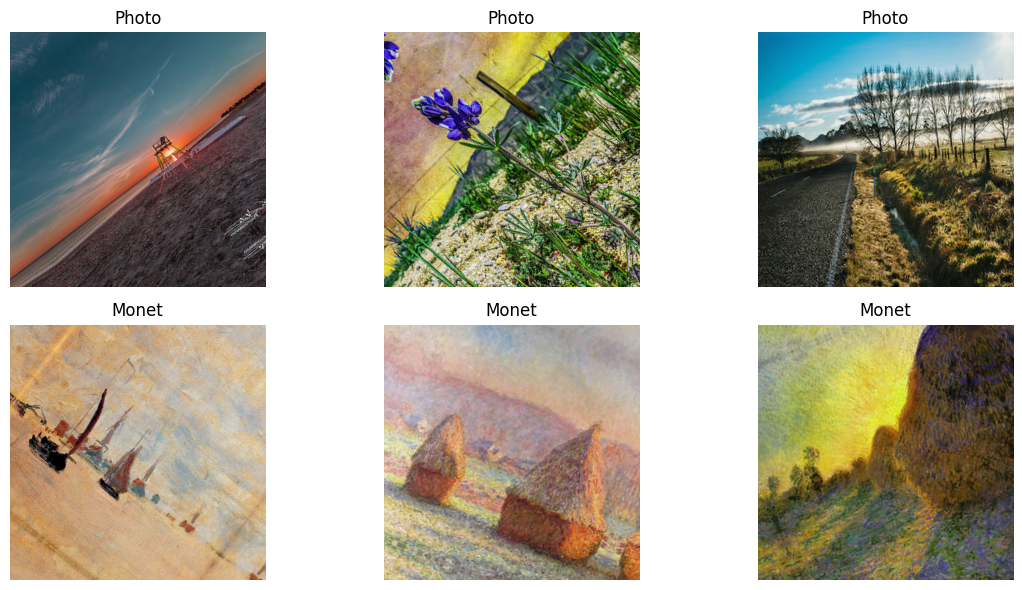

In [4]:
monet_ds = load_dataset(MONET_FILENAMES)
photo_ds = load_dataset(PHOTO_FILENAMES)

num_examples = 3

monet_iter = monet_ds.unbatch().take(num_examples)
photo_iter = photo_ds.unbatch().take(num_examples)

plt.figure(figsize=(12, 6))

for i, (photo, monet) in enumerate(zip(photo_iter, monet_iter)):
    # Photo
    plt.subplot(2, num_examples, i + 1)
    plt.title("Photo")
    plt.imshow(photo * 0.5 + 0.5)
    plt.axis("off")

    # Monet
    plt.subplot(2, num_examples, i + 1 + num_examples)
    plt.title("Monet")
    plt.imshow(monet * 0.5 + 0.5)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
print(f"Number of Monet TFEC FILES: {len(MONET_FILENAMES)}")
print(f"Number of Photo TFEC FILES: {len(PHOTO_FILENAMES)}")

Number of Monet TFEC FILES: 5
Number of Photo TFEC FILES: 20


In [6]:
def count_images_in_tfrecords(filenames):
    count = 0
    for f in filenames:
        for _ in tf.data.TFRecordDataset(f):
            count += 1
    return count

num_monet_images = count_images_in_tfrecords(MONET_FILENAMES)
num_photo_images = count_images_in_tfrecords(PHOTO_FILENAMES)

print(f"Total Monet images: {num_monet_images}")
print(f"Total Photo images: {num_photo_images}")

2025-11-27 17:48:38.898533: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-27 17:48:38.930873: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-27 17:48:39.030689: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-27 17:48:39.615086: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total Monet images: 300
Total Photo images: 7038


# 2. Building the Model

Most of this is fairly similar to the tutorial notebook. Basically I started by defining some basic functions for up and down sampling. One feature I tried adding was a residual block function to the model. I also added an additional down and up layer to the original tutorial model. I also added an additional down sample layer to the descriminator.

SInce tensor flow addons is now deprecated, I had to figure out what to replace Instance normalization with. First I simply replaced it with GroupNormalization, but then went ahead with a custom instance normalization class.

In [35]:
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=(input_shape[-1],), initializer='ones', trainable=True)
        self.beta = self.add_weight(name='beta', shape=(input_shape[-1],), initializer='zeros', trainable=True)

    def call(self, x):
        mean, var = tf.nn.moments(x, axes=[1,2], keepdims=True)
        return self.gamma * (x - mean) / tf.sqrt(var + self.epsilon) + self.beta

In [37]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    #gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        #result.add(tf.keras.layers.GroupNormalization(groups=-1,gamma_initializer=gamma_init, epsilon=1e-5))
        result.add(InstanceNormalization())

    result.add(layers.LeakyReLU(0.2))

    return result

In [38]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    #gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    #result.add(tf.keras.layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init, epsilon=1e-5))
    result.add(InstanceNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU(0.2))

    return result

To try something different, I tried adding some PixelShuffling. In the end I found that only one pixel shuffle as the first upstack layer really worked.

In [10]:
class PixelShuffleUpsample(layers.Layer):
    def __init__(self, filters, scale=2, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.scale = scale
        self.conv = layers.Conv2D(filters * (scale ** 2), kernel_size=3, padding='same')

    def call(self, x):
        x = self.conv(x)
        x = tf.nn.depth_to_space(x, self.scale)  # rearranges channels
        return x
    
def upsample_pixelshuffle(filters, apply_dropout=False):
    result = keras.Sequential()
    result.add(PixelShuffleUpsample(filters, scale=2))
    result.add(InstanceNormalization()) 
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

I also tried throughing in a few residual blocks

In [39]:
def residual_block(x):
    initializer = tf.random_normal_initializer(0., 0.02)

    filters = x.shape[-1]
    y = layers.Conv2D(filters, 3, padding='same', use_bias=False, kernel_initializer=initializer)(x)
    #y = tf.keras.layers.GroupNormalization(groups=-1)(y)
    y = InstanceNormalization()(y)
    y = layers.ReLU()(y)
    
    y = layers.Conv2D(filters, 3, padding='same', use_bias=False, kernel_initializer=initializer)(y)
    #y = tf.keras.layers.GroupNormalization(groups=-1)(y)
    y = InstanceNormalization()(y)
    
    return layers.Add()([x, y])

Below is my version of the generator and discriminator. My changed compared to the tutorial mostly consist of adding some down and up sampling to both the generator and discriminator, adding some residual layers, and throwing in a pixelshuffle upsample. 

In [ ]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
        #downsample(1024, 4),
    ]

    up_stack = [
        #upsample(512, 4, apply_dropout=True),
        #upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        #upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        #upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        #upsample(512, 4), # (bs, 16, 16, 1024)
        #upsample(256, 4), # (bs, 32, 32, 512)
        #upsample(128, 4), # (bs, 64, 64, 256)
        #upsample(64, 4), # (bs, 128, 128, 128)

        upsample_pixelshuffle(512, apply_dropout=True),  # 2 -> 4
        #upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2,padding='same', kernel_initializer=initializer, activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    for _ in range(4):  # 2 residual blocks
        x = residual_block(x)

    skips = list(reversed(skips[:-1]))  

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    #added one more downsample layer
    down0 = downsample(32, 4, apply_instancenorm=False)(x)
    down1 = downsample(64, 4, apply_instancenorm=False)(down0)
    #down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    #conv = layers.Conv2D(512, 4, strides=1,
    #                     kernel_initializer=initializer,
    #                     use_bias=False)(zero_pad1)
    conv = layers.Conv2D(1024, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

    #norm1 = tf.keras.layers.GroupNormalization(groups=-1,gamma_initializer=gamma_init,epsilon=1e-5)(conv)
    norm_layer = InstanceNormalization()
    norm1 = norm_layer(conv)

    leaky_relu = layers.LeakyReLU(0.1)(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
monet_generator = Generator() # photos to Monet-esque
photo_generator = Generator() # Monet to photos

monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photos

Sanity check that everything works:

2025-11-27 17:48:50.106135: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7232685206001866963
2025-11-27 17:48:50.106190: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7232685206001866963
2025-11-27 17:48:50.106206: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node random_rotation_1/Add/_6}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-11-27 17:48:50.106210: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7232685206001866963
2025-11-27 17:48:50.106285: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7232685206001866963
2025-11-27 17:48:50.106306: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7232685206001866963
2025-11

input shape: (1, 256, 256, 3)
min/max: -1.0004663 0.958472


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00023317337..0.979236].


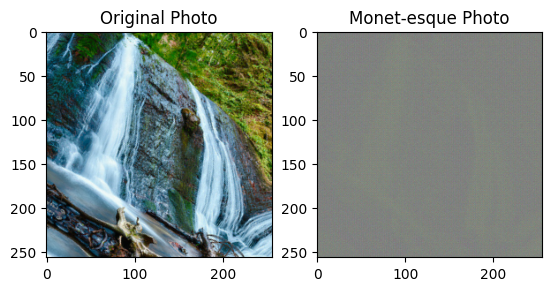

In [ ]:
example_photo = next(iter(photo_ds.unbatch().take(1)))
example_photo_batched = tf.expand_dims(example_photo, axis=0)

print("input shape:", example_photo_batched.shape)
print("min/max:", tf.reduce_min(example_photo_batched).numpy(), tf.reduce_max(example_photo_batched).numpy())

to_monet = monet_generator(example_photo_batched, training=False)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

# 3. Train the model

Next, I trained my model. The core idea is that the network generates a Monet-style image from a real photo, and a real photo from a Monet painting, then evaluates both using discriminators. For cycle consistency, a Monet image is converted to a real photo and then back to Monet, and the result is compared to the original image (the same process is applied for real => Monet => real). After computing the losses (total generator loss= adversarial + cycle + identity) the model weights are updated to improve performance.

This snippet of code was taking straight from the tutorial. The only modification I made compared to the tutorial notebook was experimenting with the learning rate and adding a learning rate scheduler.

In [16]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [ ]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = bce(tf.ones_like(real), real)
    fake_loss = bce(tf.zeros_like(generated), generated)
    return (real_loss + fake_loss) * 0.5


def generator_loss(generated):
    return bce(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [20]:
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

These are the schedulers I added to the code. I found that the discriminator was a bit too strong so I tried turning down the learning rate but turning it down too low kept crashing everything so I decided to just keep them to these:

In [21]:
gen_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=2e-4, decay_steps=10000, decay_rate=0.99, staircase=True
)

disc_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1.9e-4, decay_steps=10000, decay_rate=0.99, staircase=True
)

In [22]:
monet_generator_optimizer = tf.keras.optimizers.Adam(gen_lr_schedule, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(gen_lr_schedule, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(disc_lr_schedule, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(disc_lr_schedule, beta_1=0.5)

In [23]:
cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
    )

Now we run everything. I went with 50 cycles and let it run overnight but 20 to 30 would have been enough.

In [24]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=50
)

Epoch 1/50


2025-11-27 17:49:42.258081: I external/local_xla/xla/service/service.cc:163] XLA service 0x7dda9c002d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-27 17:49:42.258128: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-11-27 17:49:45.648569: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-27 17:50:20.670982: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_4', 4 bytes spill stores, 4 bytes spill loads



      1/Unknown 69s 69s/step - monet_disc_loss: 1.0138 - monet_gen_loss: 12.7697 - photo_disc_loss: 0.9116 - photo_gen_loss: 12.3339

I0000 00:00:1764283820.963736     990 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 97s 93ms/step - monet_disc_loss: 0.0062 - monet_gen_loss: 16.4129 - photo_disc_loss: 0.0131 - photo_gen_loss: 12.8001
Epoch 2/50


/home/wille/PythonProjects/PaintingGen/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - monet_disc_loss: 0.2065 - monet_gen_loss: 7.1842 - photo_disc_loss: 0.4363 - photo_gen_loss: 7.8819 
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - monet_disc_loss: 0.0648 - monet_gen_loss: 7.0844 - photo_disc_loss: 0.1652 - photo_gen_loss: 6.5319
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - monet_disc_loss: 0.0661 - monet_gen_loss: 7.2699 - photo_disc_loss: 0.0813 - photo_gen_loss: 7.9548
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - monet_disc_loss: 0.1020 - monet_gen_loss: 5.6595 - photo_disc_loss: 0.0760 - photo_gen_loss: 6.8109
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - monet_disc_loss: 1.0226 - monet_gen_loss: 3.6805 - photo_disc_loss: 1.3490 - photo_gen_loss: 8.2876
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - monet_disc_loss: 0.2524 - monet_gen_loss: 5.1413 - photo_disc_loss: 0.6004 - photo_gen_loss: 6.2463
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - monet_disc_l

2025-11-27 17:55:58.416625: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 29s 95ms/step - monet_disc_loss: 0.2450 - monet_gen_loss: 5.4763 - photo_disc_loss: 0.0302 - photo_gen_loss: 6.8895
Epoch 13/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - monet_disc_loss: 0.5014 - monet_gen_loss: 4.5245 - photo_disc_loss: 0.5243 - photo_gen_loss: 3.8713
Epoch 14/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 30s 99ms/step - monet_disc_loss: 1.0552 - monet_gen_loss: 4.4759 - photo_disc_loss: 2.1332 - photo_gen_loss: 3.4039
Epoch 15/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - monet_disc_loss: 0.8702 - monet_gen_loss: 3.4776 - photo_disc_loss: 1.2023 - photo_gen_loss: 3.8827
Epoch 16/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - monet_disc_loss: 0.8700 - monet_gen_loss: 3.9848 - photo_disc_loss: 0.9591 - photo_gen_loss: 5.3821
Epoch 17/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - monet_disc_loss: 0.1725 - monet_gen_loss: 4.5047 - photo_disc_loss: 0.3022 - photo_gen_loss: 8.9715
Epoch 18/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - monet_dis

2025-11-27 18:03:36.407747: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9336585153325898673
2025-11-27 18:03:36.407815: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4482126938134808226


300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - monet_disc_loss: 0.5619 - monet_gen_loss: 3.7960 - photo_disc_loss: 0.6269 - photo_gen_loss: 4.4894
Epoch 28/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - monet_disc_loss: 0.4553 - monet_gen_loss: 5.6811 - photo_disc_loss: 0.4047 - photo_gen_loss: 4.0507
Epoch 29/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - monet_disc_loss: 0.2041 - monet_gen_loss: 4.2647 - photo_disc_loss: 0.2330 - photo_gen_loss: 3.7299
Epoch 30/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - monet_disc_loss: 1.4592 - monet_gen_loss: 3.2227 - photo_disc_loss: 1.1316 - photo_gen_loss: 3.8839
Epoch 31/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - monet_disc_loss: 0.3310 - monet_gen_loss: 3.6282 - photo_disc_loss: 0.4862 - photo_gen_loss: 5.0097
Epoch 32/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - monet_disc_loss: 0.2238 - monet_gen_loss: 5.0645 - photo_disc_loss: 0.1778 - photo_gen_loss: 4.1154
Epoch 33/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - monet_d

2025-11-27 18:12:19.018653: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - monet_disc_loss: 0.1312 - monet_gen_loss: 5.6568 - photo_disc_loss: 0.2410 - photo_gen_loss: 3.6785
Epoch 45/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - monet_disc_loss: 0.4474 - monet_gen_loss: 3.4882 - photo_disc_loss: 0.5981 - photo_gen_loss: 4.2696
Epoch 46/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - monet_disc_loss: 0.7924 - monet_gen_loss: 3.0413 - photo_disc_loss: 1.1220 - photo_gen_loss: 2.1372
Epoch 47/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - monet_disc_loss: 0.1520 - monet_gen_loss: 3.3313 - photo_disc_loss: 0.1505 - photo_gen_loss: 3.5006
Epoch 48/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - monet_disc_loss: 0.5750 - monet_gen_loss: 2.9150 - photo_disc_loss: 0.6199 - photo_gen_loss: 3.6568
Epoch 49/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - monet_disc_loss: 0.5553 - monet_gen_loss: 2.7185 - photo_disc_loss: 0.2742 - photo_gen_loss: 3.1178
Epoch 50/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step - monet_di

# 3. Results

We can then plot out results for the losses. We see below that the discrimintor may be a bit too strong compared to the generator. I tried correcting for this by "weakening" the discriminator and removeing a downsample layer and by decreasing the leraning rate, but both of these kept crashing my program so I just decided to stick with what I had.

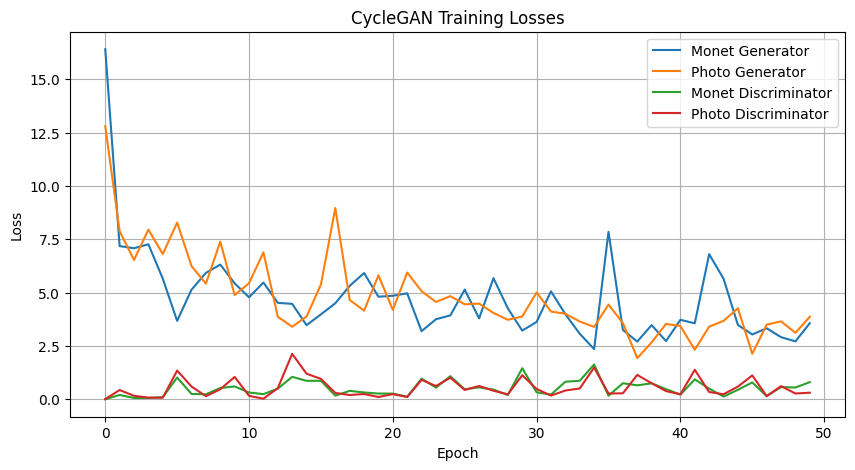

In [25]:
plt.figure(figsize=(10,5))

# Generator losses
plt.plot(history.history['monet_gen_loss'], label='Monet Generator')
plt.plot(history.history['photo_gen_loss'], label='Photo Generator')

# Discriminator losses
plt.plot(history.history['monet_disc_loss'], label='Monet Discriminator')
plt.plot(history.history['photo_disc_loss'], label='Photo Discriminator')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CycleGAN Training Losses")
plt.legend()
plt.grid(True)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0120385885..1.0357993].


input shape: (1, 256, 256, 3)
min/max: -1.0240772 1.0715985


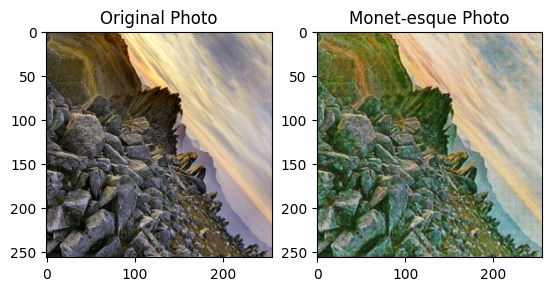

In [28]:
example_photo = next(iter(photo_ds.unbatch().take(1)))

# add batch dimension -> shape becomes [1, H, W, 3]
example_photo_batched = tf.expand_dims(example_photo, axis=0)

# optional: sanity checks
print("input shape:", example_photo_batched.shape)
print("min/max:", tf.reduce_min(example_photo_batched).numpy(), tf.reduce_max(example_photo_batched).numpy())

to_monet = monet_generator(example_photo_batched, training=False)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

# 4. Submission File

# 4. Conclusion

Getting my GAN to work ended up being very difficult as for some reason my VS code kept crashing. I ended up following the tutorial notebook by Amy Jang for help, and then went ahead and changed a few elements in an attempt to make it perform a bit better. 

In [31]:
import PIL

In [32]:
! mkdir ../images

mkdir: cannot create directory ‘../images’: File exists


In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [40]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/images'